## Лабораторная работа №2 по курсу "Алгоритмика"
### Сюй Минчуань, 5 курс

- Построение выпуклой оболочки
- Вычисление глубины множества
- Вычисление медианы
- Функция глубин

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

pd.set_option('display.max_columns', None)

In [2]:
city_data = pd.read_csv("citys.csv", delimiter = ",", encoding = 'UTF-8')
city_data.head()

,CITY,y,x,num_people
0,Абакан,53°43’,91°26’,187
1,Альметьевск,54°54’,52°18’,158
2,Ангарск,52°34’,103°55’,225
3,Арзамас,55.38,43.87,104
4,Армавир,45°00’,41°07’,189


In [3]:
def process_coordiates(data, coor_name_list):
    for name in coor_name_list:
        flag = data[name].str.contains("°")
        tmp2 = data[name].str.split("°")
        for i in range(len(tmp2)):
            if flag[i] == True: 
                tmp2[i][1] = tmp2[i][1][:-1]
                tmp2[i] = float(tmp2[i][0]) + float(tmp2[i][1])/60.0
            else: tmp2[i] = float(tmp2[i][0])
        data[name] = tmp2
    return data

In [4]:
city_data = process_coordiates(city_data, ['x','y'])
city_data.head()

,CITY,y,x,num_people
0,Абакан,53.716667,91.433333,187
1,Альметьевск,54.9,52.3,158
2,Ангарск,52.566667,103.916667,225
3,Арзамас,55.38,43.87,104
4,Армавир,45.0,41.116667,189


In [5]:
city_data[city_data['CITY'] == 'Москва']

,CITY,y,x,num_people
67,Москва,55.75,37.616667,12678


## Вычислительные сложности
- Алгоритм Джарвиса - $\mathcal{O}(nh)$, где $n$ - число всех точек, $h$ - число точек в выпуклой оболочке. - **будет использоваться в этой задаче** 
- Алгоритм Грэхема - $\mathcal{O}(n\log n)$, , где $n$ - число всех точек.

### Алгоритм Джарвиса (алгоритм заворачивания подарков)

In [6]:
def find_next(H, points, p_map):
    p_x, p_y = points[p_map[H[-1]]][0], points[p_map[H[-1]]][1]
    prev_x, prev_y = points[p_map[H[-2]]][0], points[p_map[H[-2]]][1]
    vec_a_x, vec_a_y = p_x - prev_x, p_y - prev_y 
    
    max_cos = -2
    max_i = -1
    for i in p_map.keys():
        if i not in H[1:]:
            vec_b_x, vec_b_y = points[p_map[i]][0] - p_x, points[p_map[i]][1] - p_y 
            curr_cos = (vec_a_x * vec_b_x + vec_a_y * vec_b_y) / (math.sqrt((vec_a_x**2+vec_a_y**2)*(vec_b_x**2+vec_b_y**2)) + 1e-3)
            if curr_cos > max_cos: 
                max_cos = curr_cos
                max_i = i
    if max_i == H[0]: # the start point -> finish
        return False, H
    else: 
        H.append(max_i)
        return True, H

def jarvismarch(points, p_map):
    H_list_ix = []
    
    # find the most left-lower point, and it's next point
    start_y = np.min(points, axis=0)[1]
    start_y_ix = np.argmin(points, axis=0)
    start_x = points[start_y_ix[1]][0]
    new_d = {v:k for k,v in p_map.items()} # inverse: map: index -> row_num
    H_list_ix.append(new_d[start_y_ix[1]])
     
    max_cos = -2
    max_i = -1
    for i in p_map.keys():
        if i != new_d[start_y_ix[1]]:
            v_x, v_y = points[p_map[i]][0]-start_x, points[p_map[i]][1]-start_y
            curr_cos = v_x / (math.sqrt(v_x**2 + v_y**2) + 1e-3) 
            if curr_cos > max_cos:
                max_cos = curr_cos
                max_i = i
    H_list_ix.append(max_i)
    
    # loop: iteratively find next point
    if_continue = True
    while(if_continue):
        if_continue, H_list_ix = find_next(H_list_ix, points, p_map)
    return H_list_ix

In [7]:
city_xy = np.array(city_data[['x','y']])
n_map = {i:k for i,k in enumerate(range(len(city_xy)))}
H = jarvismarch(city_xy,n_map)
H

[74, 106, 159, 92, 68, 42, 122, 128, 20, 46]

#### Визуализация метода Джарвиса

Text(0.5, 1.0, 'Cities coordiates')

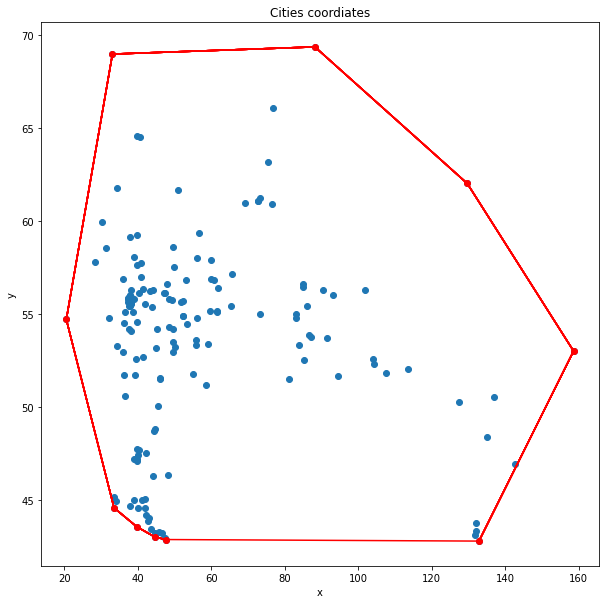

In [8]:
outer_x = [city_xy[H[i]][0] for i in range(len(H))]
outer_y = [city_xy[H[i]][1] for i in range(len(H))]

plt.figure(figsize=(10,10))
plt.scatter(city_data.x, city_data.y)
plt.scatter(outer_x, outer_y, color = 'r')
plt.plot([outer_x[-1],outer_x[0]], [outer_y[-1],outer_y[0]], color = 'r')
for i in range(len(H)):
    plt.plot(outer_x, outer_y, color = 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Cities coordiates")

### Вычисление глубины
1. Объявляем исходное множество S «текущим» множеством точек. 
2. Счетчик глубины M=0
3. Строим выпуклую оболочку текущего множества — это выпуклый многоугольник, его вершины входят в текущее множество. 
4. Если точка p оказалась среди этих вершин, то глубина точки p равна M. Тогда Выход. Иначе к 5.
5. Удаляем вершины выпуклой облочки из текущего множества (т.е. коректируем текущее множество) и полагаем M=M+1
6. Перейти к 3.

In [9]:
def depth_of_point(point_ix, points): 
    point_set = list(range(len(points)))
    M = 0
    H_list = []
    n_map = {i:k for i,k in enumerate(range(len(points)))}
    H = jarvismarch(points, n_map)
    H_list.append(H)
    while point_ix not in H:
        point_set = [k for k in point_set if k not in H] # new H_0 without H
        M = M + 1
        points_new = [points[i] for i in range(len(points)) if i in point_set]
        n_map = {k:w for w,k in enumerate(point_set)}
        H = jarvismarch(points_new, n_map)
        H_list.append(H)
    return H_list, M

#### Глубина города Москвы

In [10]:
H_list, M = depth_of_point(67, city_xy) # Moscow=67
M

7

Text(0.5, 1.0, 'Cities coordiates')

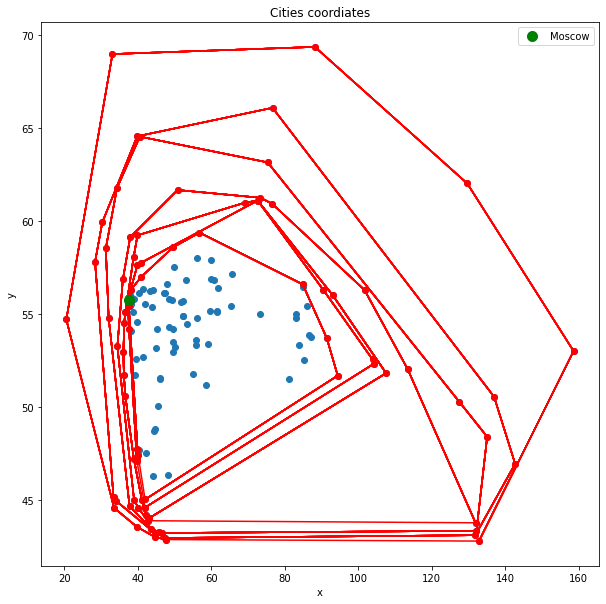

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(city_data.x, city_data.y)

for k in range(M):
    outer_x = [city_xy[H_list[k][i]][0] for i in range(len(H_list[k]))]
    outer_y = [city_xy[H_list[k][i]][1] for i in range(len(H_list[k]))]

    plt.scatter(outer_x, outer_y, color = 'r')
    plt.plot([outer_x[-1],outer_x[0]], [outer_y[-1],outer_y[0]], color = 'r')
    for i in range(len(H_list[k])):
        plt.plot(outer_x, outer_y, color = 'r')
        
# draw the Moscow
plt.plot(city_xy[67][0], city_xy[67][1], 'go', markersize=10, label = 'Moscow')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Cities coordiates")

### Глубина множества городов 

In [12]:
def max_depth_of_set(points):
    max_depth = -1
    max_depth_points = []
    for i in range(len(points)):
        _, M = depth_of_point(i, points)
        if M > max_depth:
            max_depth_points = []
            max_depth_points.append(i)
            max_depth = M
        elif M == max_depth:
            max_depth_points.append(i)
    return max_depth_points, max_depth

In [13]:
M_points, M = max_depth_of_set(city_xy)
print(M_points, M)

[29, 155] 16


Text(0.5, 1.0, 'Cities coordiates')

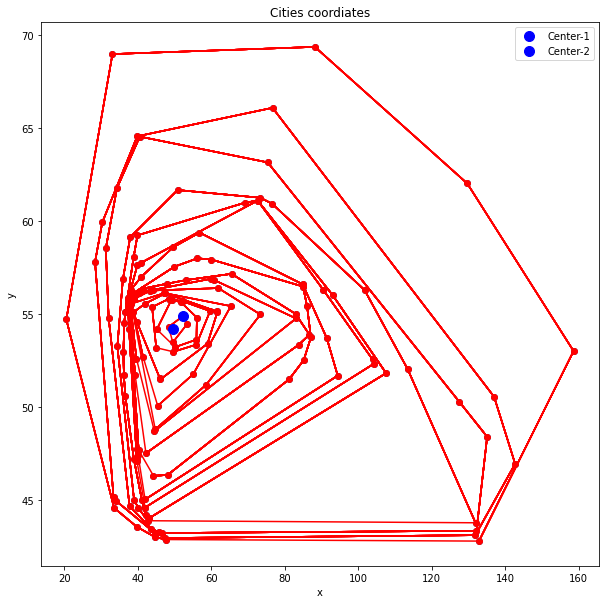

In [14]:
H_list, M = depth_of_point(29, city_xy)

plt.figure(figsize=(10,10))
plt.scatter(city_data.x, city_data.y)

for k in range(M):
    outer_x = [city_xy[H_list[k][i]][0] for i in range(len(H_list[k]))]
    outer_y = [city_xy[H_list[k][i]][1] for i in range(len(H_list[k]))]

    plt.scatter(outer_x, outer_y, color = 'r')
    plt.plot([outer_x[-1],outer_x[0]], [outer_y[-1],outer_y[0]], color = 'r')
    for i in range(len(H_list[k])):
        plt.plot(outer_x, outer_y, color = 'r')
        
# draw the centers
plt.plot(city_xy[29][0], city_xy[29][1], 'bo', markersize=10, label = 'Center-1')
plt.plot(city_xy[155][0], city_xy[155][1], 'bo', markersize=10, label = 'Center-2')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Cities coordiates")

### Функция глубин 

In [15]:
def F(m, points):
    S_m = [[] for i in range(17)]
    for i in range(len(points)):
        _, M = depth_of_point(i, points)
        S_m[M].append(i)
    return S_m, len(S_m[m])

In [16]:
# Раньше уже подсчитал, что max_depth = 16
S_m, M = F(16, city_xy)
print(S_m[16], M)

[29, 155] 2


In [17]:
city_data.iloc[['29','155']]

,CITY,y,x,num_people
29,Димитровград,54.22,49.63,113
155,Электросталь,54.9,52.3,156


In [18]:
S_m

[[20, 42, 46, 68, 74, 92, 106, 122, 128, 159],
 [19, 32, 52, 66, 72, 90, 109, 119, 123, 126, 158],
 [5, 6, 15, 18, 27, 73, 85, 93, 105, 127, 144, 146],
 [16, 17, 49, 57, 65, 78, 131, 132, 135, 142, 150, 152],
 [4, 11, 25, 43, 58, 60, 76, 94, 98, 111, 115, 133, 140, 145, 151],
 [2, 8, 10, 39, 55, 56, 75, 77, 95, 113, 138, 160],
 [0, 13, 30, 37, 48, 61, 88, 89, 107, 124, 125, 129, 147],
 [7, 14, 47, 67, 70, 81, 82, 91, 104, 110, 114, 137, 153, 156],
 [9, 23, 26, 31, 38, 40, 50, 54, 84, 86, 108, 139, 154],
 [12, 21, 22, 33, 62, 63, 80, 103],
 [24, 28, 34, 44, 97, 100, 101],
 [45, 59, 99, 112, 134, 148],
 [51, 53, 64, 69, 87, 116, 121, 149, 157],
 [3, 35, 36, 71, 83, 102, 117],
 [41, 79, 118, 120, 130, 143],
 [1, 96, 136, 141],
 [29, 155]]